
# PHYS20762 - Project 2- Numerical Integration of Differential Equations. The Damped Harmonic Oscillator

Daniel Thacker <br>
University of Manchester  
April 2021


This notebook aims to explore the solutions of a sping and mass system using four numerical integrators. The results of each numerical method will be compared with the analytical solution in each case. An accuracy will be determined for each integrator and the best time step will be found. 

Using the most accurate integrator, solutions for the damping constant at varying values will be determined, including at the critical value. 
The best method will also be used to find solutions for a 'pushed' system, ie one that has an additional force added. Additionally, a constant sinusoidal force will be added to the equation of motion for the method.

As an extra feature, the resonant frequency will be determined by varying the frequency and analysing the resulting amplitude. This will be compared to a power / frequency curve and a Q value for the system will be calculated. 
The user is then encouraged to explore the best method by inputting numbers to change the parameters of the spring, observing the resultant displacement graph. Note in order to run specific cells in this notebook the programme at the end must be ran and turned off when prompted.

Importing and set paramters. Code below sets jupyter to not create a scroll wheel for graphs.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [2]:
#importing and set parameters
import string
import cmath
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random

plt.rcParams.update({'font.size': 14})
plt.style.use('default')


In [3]:
#initial constants
k = 0.89 # kg s^-2 # sping constant
m = 2.92 # kg # spring mass
b = 0.08 # kg s^-1 damping term


#ANALYTICAL SOLUTION 
#for when critical damping does not apply
def analytical(x0, v0, time, b):
    "Calculates the analytical solution for displacement and speed that is used throughout this notebook."
    "Found from [3]. The speed was found via differentiating x. Takes in an array of time values and the"
    "damping constant, b."
    
    A = (b/(2*1j*cmath.sqrt(4*k*m-b**2))+0.5)*x0+v0*m/(cmath.sqrt(4*k*m-b**2)*1j)
    B = x0 - A
    
    x_analytical = np.exp(-(b/m)*time/2)*(A*np.exp(1j*cmath.sqrt(4*k*m-b**2)*time/(2*m))
                                              +B*np.exp(-1j*cmath.sqrt(4*k*m-b**2)*time/(2*m)))
    
    v_analytical = ((((1j*A*cmath.sqrt(4*k*m-b**2))-A*b)*(np.exp(1j*(cmath.sqrt(4*k*m-b**2)*time/m)))
                                            -1j*B*(cmath.sqrt(4*k*m-b**2))-b*B)*np.exp(
        (-1j*(cmath.sqrt(4*k*m-b**2))*time/(2*m))-((b*time)/(2*m))))/(2*m)

    return x_analytical, v_analytical


#start with Euler's method
def eulers_method(time, h, initial_x, initial_v, b):
    "Integration method derived from the Taylor expansion of x(t+h) to 3rd order"
    "Accepts a total time value, time step h (s), damping term b and initial conditions."
    
    #Determines how many steps we have in the algorithm. 
    #Int so a whole number.
    nsteps = int(time/h)
    
    #Empty arrays to contain the x and v values
    x = np.zeros(nsteps)
    
    v = np.zeros(nsteps)

    #inital conditions
    x[0] = initial_x
    
    v[0] = initial_v
    
    #iterate over step number and find acceleration, displacement and speed
    #at each step
    for i in range(nsteps-1):
        
        #Calculate acceleration at step i
        
        a = -(k/m)*x[i] - (b/m)*v[i]
        
        #x and v at a later step i+1
        
        x[i+1] = x[i] + v[i]*h
        
        v[i+1] = v[i] + a*h
        
    return x, v
    

In [4]:
def improved_euler(time, h, initial_x, initial_v, b):
    "An improvement to the Euler method via adding an additional term to the Taylor"
    "expansion of (x+h)."
    "Accepts a total time value, time step h (s), damping term b and initial conditions."
    
    #Determines how many steps we have in the algorithm. 
    #Int so a whole number.
    nsteps = int(time/h)
    
    #Empty arrays to contain the x and v values
    x = np.zeros(nsteps)
    
    v = np.zeros(nsteps)
    
    #inital conditions
    x[0] = initial_x
    
    v[0] = initial_v
    
    
    for i in range(nsteps-1):
        
        #Calculate acceleration at step i
        a = -(k/m)*x[i] - (b/m)*v[i]
        
        #x and v at a later step i+1 involving an additional term in
        #the taylor series expansions of x(t+h) and v(t+h)
        x[i+1] = x[i] + v[i]*h + (h**2)*a/2
        
        v[i+1] = v[i] + a*h
    
    return x, v
    

In [5]:
def verlets_method(time, h, initial_x, initial_v, b):
    "Derived via taking the centred derivative of the displacement after some timestep h."
    "The order of error is now a quartic in h, therefore we expect this method to be more"
    "accurate. Note this method is not self starting due to the x[i-1] term. The Euler method"
    "is used for the starting values."
    "Accepts a total time value, time step h (s), damping term b and initial conditions."
    
    #Determines how many steps we have in the algorithm. 
    #Int so a whole number.
    nsteps = int(time/h)
    
    #Empty arrays to contain the x and v values
    x = np.zeros(nsteps)
    
    v = np.zeros(nsteps)
    
    #t = np.array([])
    
    #inital conditions
    x[0] = initial_x
    
    v[0] = initial_v
    
    #t = np.append(t,0)
    
    for i in range(nsteps-1):
        
        #Calculate acceleration at step i
        a = -(k/m)*x[i] - (b/m)*v[i]
        
        if i==0:
            
            #initial first step must be approximated, 
            #use eulers method
            x[i+1] = v[i]*h + (h**2)*(-(b/m)*v[i])/2
            
            v[i+1] = v[i] + a*h
            
        else:
        
        #Writing 2 taylor expansions for x at x(t+h) and x(t-h)
        #and using a centered derivative leads to the equations
        #The first term must be approximated using the Euler method as above
            D = 2*m + b*h
        
            A = 2*(2*m-k*(h**2))/D
        
            B = (b*h-2*m)/D
        
            x[i+1] = A*x[i] + B*x[i-1] 
        
            v[i+1] = (x[i+1] - x[i-1])/(2*h)
        
    return x, v
    

In [6]:
def euler_cromer(time, h, initial_x, initial_v, b):
    "Integration method derived from the Euler method. An additional term is added to"
    "account for the speed at the next step v[i+1] in the calculation of the next displacement."
    "Energy should be conserved as a result, unlike the Euler method."
    "Accepts a total time value, time step h (s), damping term b and initial conditions."
    
    #Determines how many steps we have in the algorithm. 
    #Int so a whole number.
    nsteps = int(time/h)
    
    #Empty arrays to contain the x and v values
    x = np.zeros(nsteps)
    
    v = np.zeros(nsteps)
    
    E = np.zeros(nsteps)
    
    #inital conditions
    x[0] = initial_x
    
    v[0] = initial_v
    
    #add an extra damped term to the x[i+1] term that considers the proceeding speed 
    for i in range(nsteps-1):
        
        a = -(k/m)*x[i] - (b/m)*v[i]
        
        v[i+1] = v[i] + a*h
        
        x[i+1] = x[i] + h*v[i+1]

    return x, v
    

Now we have set up each integration method, we will compare the results to analytical solutions, using a fixed value for h, b and time.

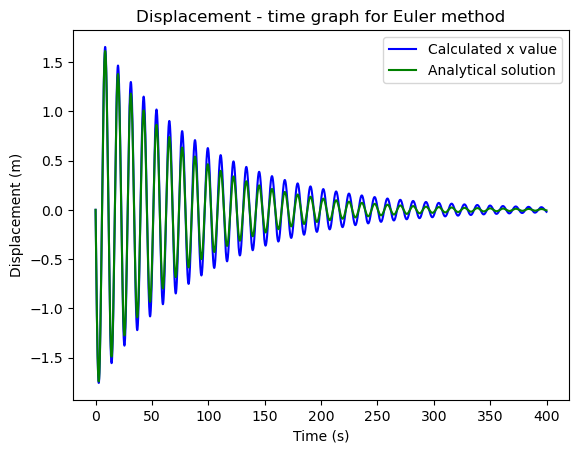

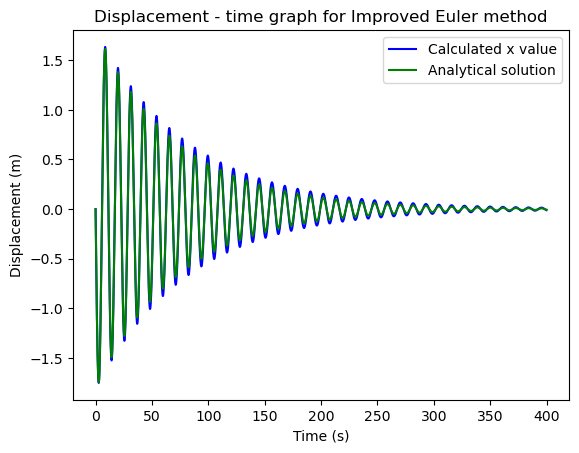

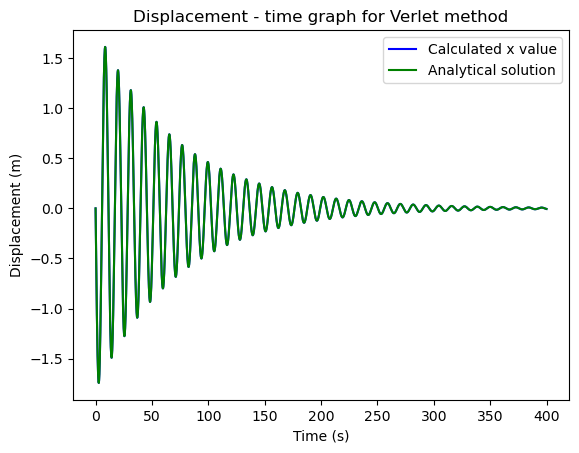

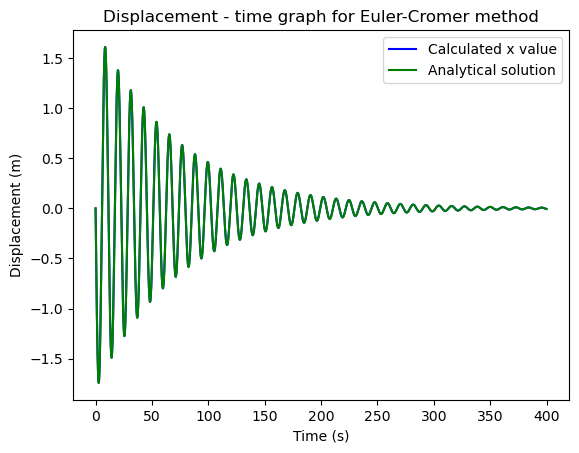

In [7]:

def displacement_time(time, h, initial_x, initial_v, method, title):
    "Function that takes in initial parameters and the method name, which changes the"
    "integration method used to calculate the displacement. The title is simply a string"
    "used to change the graph titles."
    "Returns plots for all displacement values resulting from each method and compares"
    "them to the analytical solution."
    
    #find the time for which the integration methods opperate 
    t = np.arange(0, time, h)
    
    #using each method, finds the displacement
    x = method(time , h, initial_x, initial_v, b)[0]
    
    #determine the analytical solution for this time value
    x_analytical = analytical(initial_x, initial_v, t, b)[0].real 
    
    #plots each displacement on an individual graph against the analytical solution
    displacement_time_figure = plt.figure(5)

    displacement_time = displacement_time_figure.add_subplot(111)

    displacement_time.set_title('Displacement - time graph for ' + title)

    displacement_time.set_xlabel("Time (s)")

    displacement_time.set_ylabel("Displacement (m)")

    displacement_time.plot(t, x, 'b', label='Calculated x value')
    
    displacement_time.plot(t, x_analytical, 'g', label='Analytical solution')
    
    displacement_time.legend(loc='upper right')
    
    plt.show()

#compile a list of a methods for iterating through
integration_methods = (eulers_method, improved_euler, verlets_method, euler_cromer)

#compile a list of a method graph titles for iterating through
titles = ('Euler method', 'Improved Euler method', 'Verlet method', 'Euler-Cromer method')

for method, title in zip(integration_methods, titles):
    
    displacement_time(400, 0.02, 0, -1, method, title)


From these graphs, it is clear that the Euler method is least accurate in comparrison to the analytical solution,
followed by the improved Euler method, which shows slightly less difference between analytical and calculated values. 
The Verlet and Euler-Cromer method are more difficult to discern between each other. 
Now let's vary the step size to get a better understanding of which is most accurate, and which stepsize is best. 

We will compare energies of each integrator to see how accurately energy is calculated in each method. We will use the analytical solution provided in the analytical function used previously, this time with velocity as well. The energy will be found using the sum of kinetic and potential energy. A difference value between the calculated and analytical solution will be found for each element in each energy array and mean will be found. This will be repeated for a number of different step sizes, to determine which stepsize is best.

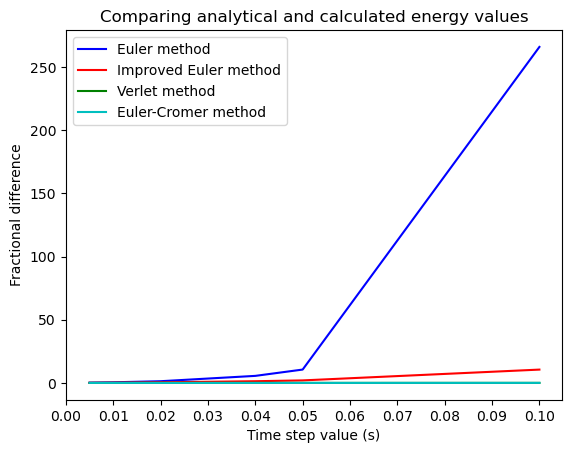

In [8]:
def energy(x, v):
    "A simple funtion that takes an array of displacement and velocity values to determine the energy using"
    "the standard formula for both kinetic and potential energy."
    
    return 0.5*m*v**2 + 0.5*k*x**2

def vary_h_energy(time , initial_x, initial_v, method, h_values, name, colour):
    "This function aims to determine a difference between the analytical and calculated energy"
    "values for each method for a range of step sizes."
    "An array of timesteps is iterated through, calculating the analytical and numerical values"
    "of speed and displacement each time."
    "The energy is calculated accordingly, using the energy function. The fractional difference in analytical"
    "and calculated value at each point is averaged for each time step and plotted on a graph for each method."
    "'method' argument determines the method used, name and colour are simply used to add to the graph"

    #set up an empty array for the summed difference values to be added  
    sum_values = np.array([])
    
    for h in h_values:
        
        t = np.arange(0, time, h)

        #Calculate analytical energy 
        x_ana = analytical(initial_x, initial_v, t, b)[0].real
        
        v_ana = analytical(initial_x, initial_v, t, b)[1].real
    
        energy_analytical = energy(x_ana, v_ana)
        
        #Calculate the displacement and speed values with each method
        x = method(time, h, initial_x, initial_v, b)[0]
        
        v = method(time, h, initial_x, initial_v, b)[1]
        
        #find the difference in analytical and calculated energy, using x and v, and divide by
        #the analytical energy to find a fraction.
        difference = np.abs((energy_analytical - energy(x, v))/energy_analytical)

        #average the difference in solution and add to an array
        sum_difference = np.mean(difference)

        sum_values = np.append(sum_values, sum_difference)
        
        
    plt.plot(h_values, sum_values, colour, label=name)
    
    plt.legend(loc='upper left')
    
    plt.title('Comparing analytical and calculated energy values')
    
    plt.xlabel("Time step value (s)")
    
    plt.ylabel("Fractional difference")
    
    plt.xticks(np.arange(0,0.11,0.01))
    
    return 0
       
h_range = [0.005,0.01,0.02,0.04,0.05,0.1]

colour = ('b', 'r', 'g', 'c')

for method, title, colour in zip(integration_methods, titles, colour):
    
    vary_h_energy(250, 0, -1, method, h_range, title, colour)




It appears that the Euler and Improved Euler method are inaccurate compared to the verlet and Euler-Cromer method in terms of energy as they converge much less quickly than Verlet and Euler-Cromer to near zero difference. The Verlet and Euler-Cromer at low timesteps show very little deviation from the actual value.
Reasons for the fact the Verlet and Cromer method deviate less from the true value could be that they are energy conserving: they do not increase the energy of the solution [1]. 

It appears the solutions all converge as step size decreases. This is what we would expect. The Verlet method, for instance, has an error that scales as the quartic of h. For the Improved Euler this would scale as the cube of h [1]. It makes sense, therefore, that the Verlet method converges to the analytical solution with less error, the smaller the time step values.

It is difficult from this graph to distinguish betweent the Verlet and Euler-Cromer methods, since they appear even in convergence, hence we will analyse them closer and determine the most accurate one.
We will use the value of time as 250 s. The logic behind this value is that the displacement time graphs above have mostly stopped reducing in amplitude at 250 s, so this value will allow the most oscillations to be averaged over a significant period of time.

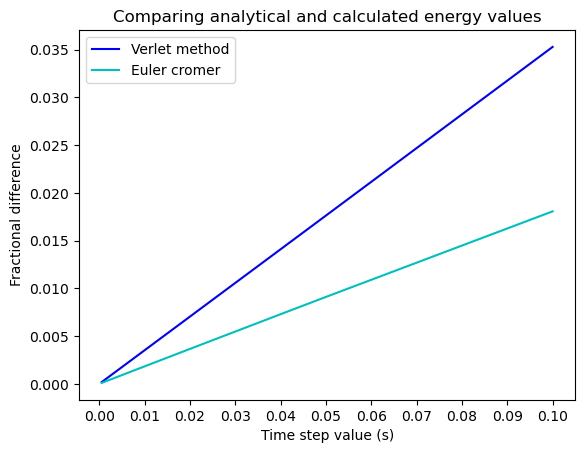

In [9]:

new_methods = (verlets_method, euler_cromer)

new_titles = ('Verlet method', 'Euler cromer')

new_colours = ('b', 'c')

#pick a range of h with a smaller value
h_range_new = [0.0005,0.005,0.01,0.02,0.04,0.05,0.1]

for method, title, colour in zip(new_methods, new_titles, new_colours):
    
    vary_h_energy(250, 0, -1, method, h_range_new, title, colour)


This difference analysis suggests that the most accurate method, with the lowest truncation error, is the Euler-Cromer
method, as the difference in analytical and calculated value increases the least with increased time step value.The methods converge to roughly zero fractional difference at 0.0005 s time step. This will not be used for the remainder of the analysis since it is unreasonably small and would take too much time to run.

The desired accuracy is one in which the run time is not too long, but with the highest degree of accuracy. A difference for analytical solution of half a percent is sufficient to calculate all necessary measurements, and has been found to not overburden the runtime. Consequently, a step size of 0.025 s will be used for the remainder of the experiment. This has produced, for the Euler Cromer method, a difference percentage of below 0.5%.



Now let's explore what happens when the damping term is changed for the Euler-Cromer method, as it is most accurate.
Heavy damping occurs when $(\frac{b}{m})^2/4$ is greater than the natural frequency squared $(\frac{k}{m})^2$ [3].

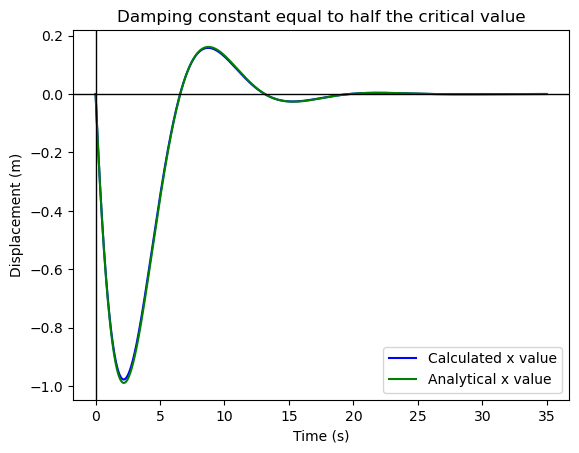

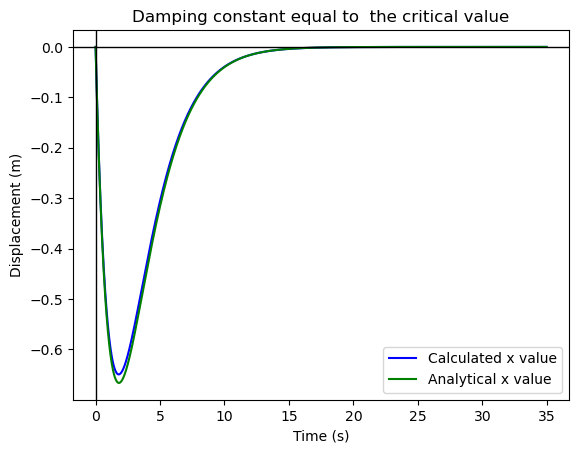

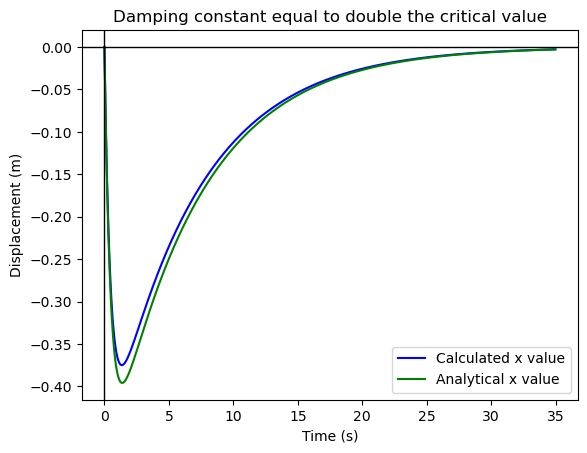

In [10]:
#set the critical value
b_critical = np.sqrt(4*k*m)

#set a range of damping terms to explore, equal to the critical value, half the critical value, and double
damping_terms = (0.5*b_critical, b_critical, 2*b_critical)

#first, create the analytical solution for critical damping, the solution used previously will not work 
#in this specific case
def analytical_critical_damping(time, damping_term, initial_x, initial_v):
    "Returns analytical solution of critical damping. Derived using method from [3]."
    "Accepts an array of time values along with intitial conditions."
    
    gamma = damping_term/m
    
    A= initial_x
    
    B= initial_v + ((A*gamma)/2)
    
    return (np.exp((-gamma*time)/2))*(A +(B*time))


def vary_damping(time, h, initial_x, initial_v, title, damping_term):
    "A function that takes in all start parameters plus a title and damping term. Calculates"
    "the analytical solution and Euler-Cromer solution for 3 damping terms from the array."
    "Changes the title accordlingly by iterating through the list."
    
    #find the time for which the integration methods opperate 
    t = np.arange(0, time, h)
    
    #Find the analytical solution in each case
    if damping_term == b_critical:
        
        x_analytical = analytical_critical_damping(t, damping_term, initial_x, initial_v)
        
    else:
        
        x_analytical = analytical(initial_x, initial_v, t, damping_term)[0].real
        
    #using each damping term, finds the displacement
    x = euler_cromer(time , h, initial_x, initial_v, damping_term)[0]
    
    #plots each displacement on an individual graph against the analytical solution
    damping_figure = plt.figure(5)

    damping = damping_figure.add_subplot(111)

    damping.set_title('Damping constant equal to ' + title + ' the critical value')

    damping.set_xlabel("Time (s)")

    damping.set_ylabel("Displacement (m)")

    damping.plot(t, x, 'b', label='Calculated x value')
    
    damping.plot(t, x_analytical, 'g', label='Analytical x value')
    
    damping.legend(loc='lower right')
    
    damping.axhline(y=0, color='k', linewidth=1.0)
    
    damping.axvline(x=0, color='k', linewidth=1.0)
    
    plt.show()
    
    return 0 

#set a list of damping titles to iterate through for the graphs
damping_titles = ('half', '', 'double')

#iterate through each damping term, changing the graph titles accordingly
for term, title in zip(damping_terms, damping_titles):
    
    vary_damping(35, 0.025, 0, -1, title, term)


From the graphs it appears at critical damping the system approaches zero in the shortest time. 
At half the critical value, the spring-mass system hits the origin point more quickly but oscillates around it for some time.

At double the critical value, the system does not see any residual oscillation, but slowly moves towards the equilibrium
position, in a greater time than the other damping terms.

The analytical and calculated values are in reasonable agreement with each other, showing the integrator works as intended at specific values of damping.

Now we will explore how the integrators cope with adding an external force (a push) after a few oscillations. We will do this for both in the direction of velocity and against it, at a number of different steps in the oscillation.

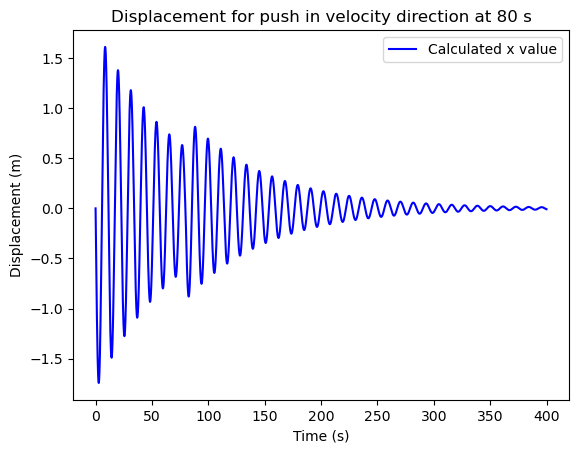

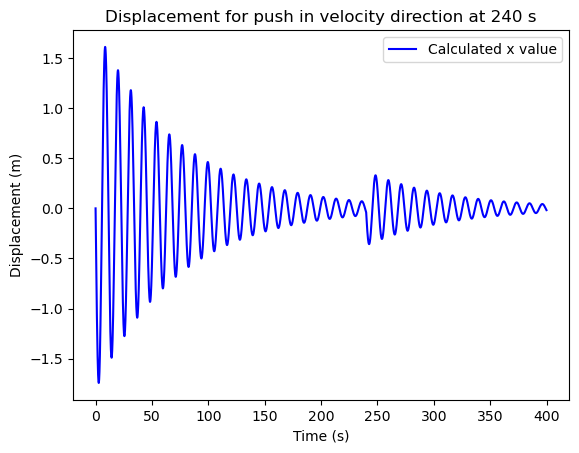

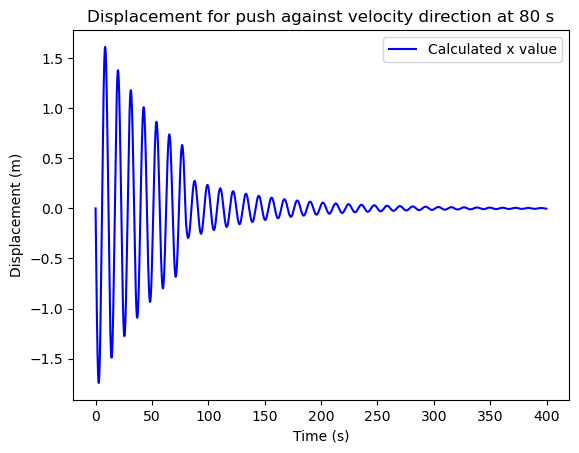

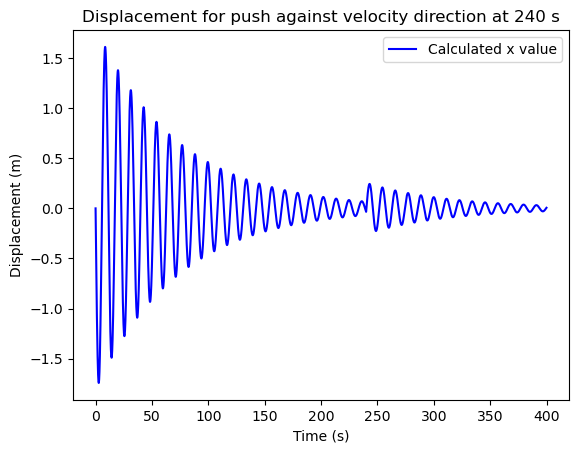

In [11]:

def euler_cromer_pushed(time, h, initial_x, initial_v, b, force, force_position, sign, sign_boolean):
    "Funtion that accepts the usual intial conditions and the force, which determines the magnitude"
    "of the push by adding an extra term to the acceleration to the Euler Cromer method."
    "Force_position sets the step number index of the added force."
    "Sign is simply a string that is used to add to the produced graph."
    "sign _booleans is either true or false and is used to determine whether the push is in the positive"
    "or negative v direction."
    "Returns plots of displacement against time."
    
    #Determines how many steps we have in the algorithm. 
    #Int so a whole number.
    nsteps = int(time/h)
    
    t = np.arange(0, time, h)
    
    #Empty arrays to contain the x, v and force values
    x = np.zeros(nsteps)
    
    v = np.zeros(nsteps)
    
    f = np.zeros(nsteps)
    
    #inital conditions
    x[0] = initial_x
    
    v[0] = initial_v
    
    #Add in a push for the system, finding where the velocity is either positive or negative and 
    #adding a push accordingly. The sign_boolean term that is input into the function determines this.
    f[force_position] = force
    
    for i in range(nsteps-1):
        
        if v[i] < 0 == sign_boolean:
 
            a = -f[i]/m -(k/m)*x[i] - (b/m)*v[i]
        else:

            a = f[i]/m -(k/m)*x[i] - (b/m)*v[i]
        
        v[i+1] = v[i] + a*h
        
        x[i+1] = x[i] + h*v[i+1]
        
    pushed_time_figure = plt.figure(5)

    pushed_time = pushed_time_figure.add_subplot(111)

    pushed_time.set_title('Displacement for push ' + sign + 
                          ' velocity direction at {0:.0f} s'.format(force_position*h))

    pushed_time.set_xlabel("Time (s)")

    pushed_time.set_ylabel("Displacement (m)")

    pushed_time.plot(t, x, 'b', label='Calculated x value')

    pushed_time.legend(loc='upper right')
    
    plt.show()
    
    return 0


#Choose a range of step number positions to add the push, to investigate how the model reacts to 
#the change in acceleration at different points in the oscillation.
#Also changes the sign of the acceleration to that of the initial velocity.

#For a chosen time step and time value, calculate a range of fractions of total time for which to add the push
step_fractions = (0.2, 0.6)

total_time = 400

time_step = 0.025

#how strong is the push (N)
force_const = 20

#Look at pushes at 2 different position values, each in the direction of the instaneous velocity at that point
for fraction in step_fractions:

    euler_cromer_pushed(total_time, time_step, 0, -1, b, force_const, int(fraction*(total_time/time_step)), 'in', False)
    
#Now see the same push positions but with the force in the opposite direction to the push
for fraction in step_fractions:

    euler_cromer_pushed(total_time, time_step, 0, -1, b, force_const, int(fraction*(total_time/time_step)), 'against', True)

From these graphs it appears adding a force in the same direction as the velocity causes the displacement, unsurpsingly,  
to increase. This is what we would expect. The opposite is true for the reversed case. The resultant amplitude immediately
after the push is dependant on the displacement before it, as seen by the difference in jump values for the 80s and 200s 
graphs. The amplitude reduces faster when the push is against the velocity direction.


We will now look at a sinusoidal forced oscillation using the Euler Cromer method.


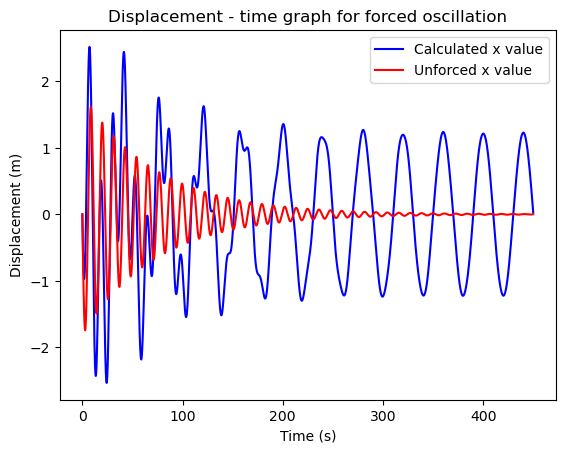

In [12]:

def euler_cromer_forced(time, h, initial_x, initial_v, b, force_const, force_frequency):
    "Now apply a sinusoidal force to the euler_cromer method by adding a cos term to the acceleration."
    "force_const determines the max force, while force_frequency determines the frequency of oscillation."
    "Returns displacement, analytical displacement and time to be plotted."
    
    #Determines how many steps we have in the algorithm. 
    #Int so a whole number.
    nsteps = int(time/h)
    
    t = np.arange(0, time, h)
    
    #set the constant force
    f = force_const*np.cos(2*np.pi*force_frequency*t)
    
    unforced_x = euler_cromer(time, h, initial_x, initial_v, b)[0]
    
    #Empty arrays to contain the x and v values
    x = np.zeros(nsteps)
    
    v = np.zeros(nsteps)
    
    #inital conditions
    x[0] = initial_x
    
    v[0] = initial_v
    
    for i in range(nsteps-1):
        
        a = f[i]/m -(k/m)*x[i] - (b/m)*v[i]
        
        v[i+1] = v[i] + a*h
        
        x[i+1] = x[i] + h*v[i+1]
        
    return x, unforced_x, t

#calculate the x, x analytical and time values to be plotted. 
#Uses a force constant of 1 N and frequency of oscillation 0.025 Hz
#These values have been found to demonstrate a clear level of transient response
x, x_ana, t = euler_cromer_forced(450, 0.025, 0, -1, b, 1, 0.025)

forced_time_figure = plt.figure(6)

forced_time = forced_time_figure.add_subplot(111)

forced_time.set_title('Displacement - time graph for forced oscillation' )

forced_time.set_xlabel("Time (s)")

forced_time.set_ylabel("Displacement (m)")

forced_time.plot(t, x, 'b', label='Calculated x value')
    
forced_time.plot(t, x_ana, 'r', label='Unforced x value')

forced_time.legend(loc='upper right')
    
plt.show()


The forced oscillation graph shows a transient state for about 200s before reducing to a steady oscillation. The transient
motion matches with the unforced displacement value, implying the transient state is a result of a superposition
betweeen the unforced motion of the mass with the driving force. The steady state is reached when the unforced motion is
neglible. 

A plot of amplitude against driving frequency will be made to investigate the effect of resonance.
The resonant frequency will be $\frac{1}{2\pi}(\frac{k}{m})^\frac{1}{2}$ which is $\frac{1}{2\pi}$ times the natural angular frequency [2]. Frequency values around this number will be plotted against the maximum resulting displacement. 
Resonance is the phenomenon that causes an increase in amplitude of a driven system at the natural frequency [3].

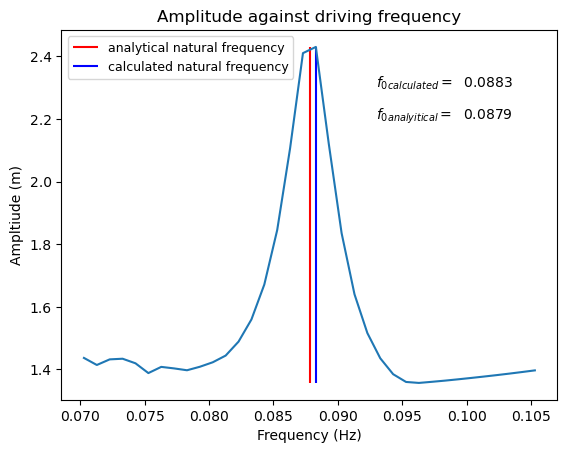

In [13]:
#analytical natural frequency from [3]
freq_natural = (1/(2*np.pi))*(k/m)**0.5

#set a range of frequency values to apply to the euler_cromer_forced function
frequency_range = np.arange(freq_natural*0.8, freq_natural*1.2, 0.001)

#set array for which to add the amplitude values
amplitude = np.array([])

#choose a sensible force value
f0 = 0.11

#iterate over the frequency range and find the highest displacement value for each frequency
for frequency in frequency_range:
    
    amplitude = np.append(amplitude, np.max(euler_cromer_forced(400, 0.05, 0, -1, b, f0, frequency)[0]) )

#calculate the natural frequency using when the amplitude is maximum    
calculated_nat_frequency = frequency_range[np.argmax(amplitude)]

resonance_figure = plt.figure(7)

resonance = resonance_figure.add_subplot(111)

resonance.plot(frequency_range, amplitude)

resonance.set_xlabel('Frequency (Hz)')

resonance.set_ylabel('Ampltiude (m)')

resonance.set_title('Amplitude against driving frequency')

#plot the analytical natural frequency
resonance.vlines(x=freq_natural, ymin=np.min(amplitude), ymax=np.max(amplitude), color='r', label='analytical natural frequency')

#plot the calculated natural frequency
resonance.vlines(x=calculated_nat_frequency, ymin=np.min(amplitude), ymax=np.max(amplitude), color='b', label='calculated natural frequency')

resonance.text(0.093,2.3,'$f_{0calculated} = $ ' + ' {0:4.4f}'.format(calculated_nat_frequency))

resonance.text(0.093,2.2,'$f_{0analyitical} = $ ' + ' {0:4.4f}'.format(freq_natural))

resonance.legend(loc='upper left', prop={'size':9})

plt.show()


The analytical natural frequency is shown on the plot. The expected shape is seen, with increasing amplitude as frequency
is closer to the natural frequency. The analytical and calculated natural frequencies are in agreement with each other,  up to 3 significant figures, with the largest error for the calculated value being from the step size of the frequency range.



We will explore how power is conserved in this method and see if resosance has an effect on power output. The power values around one oscillation (after the transient period has expired) will be summed together (calculated via $p = vf$ )  and divided by the time period to obtain an average power for the system at each oscillation.

The quality factor, $Q$, is the ratio of energy stored in an oscillator to the energy 
dissipated per radian [3]. For a power/resonance curve, it has the value $Q =\frac{f_0}{f_{fwhm}}$ , where $f_{fwhm}$ is the width of frequency at half the max power value and $f_0$ is the natural frequency.

The $Q$ value can also be defined as $Q=\frac{\omega_0}{\gamma}$ where $\gamma$ is $\frac{b}{m}$ and ${\omega_0}$ is the natural angular frequency. This allows us to compare an analytical and calculated value for the $Q$ value.


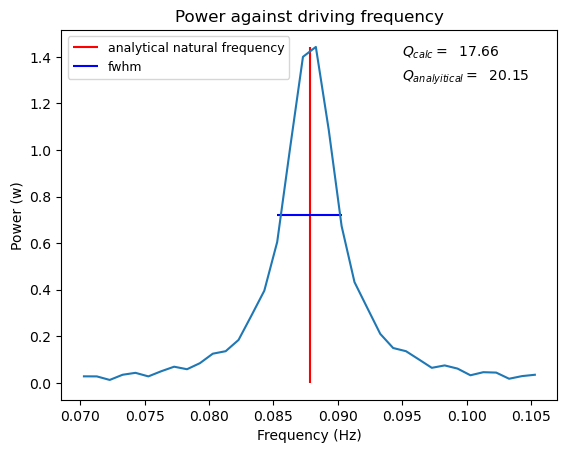

In [14]:

def euler_cromer_forced_period(time, h, initial_x, initial_v, b, force_const, force_frequency):
    "Accepts the same arguments as euler_cromer_force. This functions calculates the time period"
    "and the number of steps in the time period to find a range of velocity and force values"
    "after the transient period has expired (guessed as 320s into the oscillation.)"
    
    #Determines how many steps we have in the algorithm. 
    #Int so a whole number.
    nsteps = int(time/h)
    
    #calculate time period
    time_period = 1/force_frequency
    
    #number of steps in a period
    period_steps = int(time_period/h)
    
    t = np.arange(0, time, h)
    
    f = force_const*np.cos(2*np.pi*force_frequency*t)
    
    #set empty array for power values to be put into an array around the period
    power_values_period = np.array([])
    
    #Empty arrays to contain the x and v values
    x = np.zeros(nsteps)
    
    v = np.zeros(nsteps)
    
    #inital conditions
    x[0] = initial_x
    
    v[0] = initial_v
    
    for i in range(nsteps-1):
        
        a = f[i]/m -(k/m)*x[i] - (b/m)*v[i]
        
        v[i+1] = v[i] + a*h
        
        x[i+1] = x[i] + h*v[i+1]
        
        #Giving enough time for the transient period to expire, find the velocity and power values over 
        #one period, multiply them together then add to an array to be summed
        if (nsteps*0.8 - 0.5*period_steps) <= i <= (nsteps*0.8 + 0.5*period_steps):
            
            power_values_period = np.append(power_values_period, v[i]*f[i])
        
    #sum power over the period and divide by time period to find an average for the oscillation
    power_oscillation = np.sum(power_values_period)/time_period
            
    return power_oscillation

def fwhm_finder(frequencies, power_values):
    
    #find half the max power value
    power_fwhm = 0.5*np.max(power_values)
    
    #find the absolute difference between the half power value and all the power values
    difference_fwhm = np.abs(power_fwhm-power_values)

    #sort by smallest difference values and find the first 2
    smallest_index = np.argpartition(difference_fwhm, 2)
    
    #return the frequency using this index
    return frequencies[smallest_index[:2]]

    

#create empty array for the average powers over one cycle to be added
power_cycle = np.array([])

#iteration over the frequency range as before, this time returning average power for each oscillation
for frequency in frequency_range:
    
    power_cycle = np.append(power_cycle, euler_cromer_forced_period(400, 0.05, 0, -1, b, f0, frequency))

#find the fwhm frequencies
x_max, x_min = fwhm_finder(frequency_range, power_cycle)

#calculate Q value from equation in markdown cell
Q_value_calc = calculated_nat_frequency/(x_max-x_min)

#calculate Q value from analytical quantities
Q_value_analytical = (2*np.pi*freq_natural)/(b/m)

#plot the power against frequency
power_resonance_figure = plt.figure(8)

power_resonance = power_resonance_figure.add_subplot(111)

power_resonance.plot(frequency_range, power_cycle)

power_resonance.set_xlabel('Frequency (Hz)')

power_resonance.set_ylabel('Power (w)')

power_resonance.set_title('Power against driving frequency')

power_resonance.vlines(x=freq_natural, ymin=0, ymax=np.max(power_cycle), color='r', label='analytical natural frequency')

power_resonance.hlines(xmin=x_min, xmax=x_max, y=0.5*np.max(power_cycle), color='b', label='fwhm')

power_resonance.text(0.095,1.4,'$Q_{calc} = $ ' + ' {0:4.2f}'.format(Q_value_calc))

power_resonance.text(0.095,1.3,'$Q_{analyitical} = $ ' + ' {0:4.2f}'.format(Q_value_analytical))

power_resonance.legend(loc='upper left', prop={'size':9})

plt.show()


The power resonance curve is seen above. It matches the amplitude/ frequency graph as expected from [2], with a peak matching the natural frequency. The fwhm is seen, slightly off-centre, most likely due to the resolution of the frequency.

The $Q$ values are seen on the graph, they show a reasonable level of agreement with each other, with about a 10% difference. There can be reasonable level of confidence, therefore, that the method used is valid.


As a final extra feature, the user is encouraged to explore the Euler Cromer method by changing the time, intitial conditions, time step and damping term. Note that some very high values will cause the programme to run slowly. 

In [ ]:

while True:
    while True:
        try:
            TIME_CHOSEN = float(input("What would you like the run-time"
                                         " of the method to be in seconds? "))
            if TIME_CHOSEN <= 10:
                raise ValueError
            break
        except ValueError:
            print("Invalid input! Time must be a number above ten seconds.")
            
    while True:
        try:
            INITIAL_DISPLACE = float(input("What would you like the initial displacement"
                                         " of the spring to be in metres? "))
            break
        
        except ValueError:
            print("Invalid input! This must be a number.")
            
    while True:
        try:
            INITIAL_VELOCITY = float(input("What would you like the initial velocity"
                                         " of the spring to be in metres per second? "))
            break
        
        except ValueError:
            print("Invalid input! This must be a number.")

    while True:
        try:
            TIMESTEP_CHOSEN = float(input("What would you like the timestep"
                                         " of the method to be in seconds? "))
            if TIMESTEP_CHOSEN >= TIME_CHOSEN:
                raise ValueError
            break
        except ValueError:
            print("Invalid input! Timestep must be a number above the total time.")


    while True:
        try:
            DAMPING = float(input("What would you like the damping constant"
                                         " of the spring to be in kg s^-1? "))
            if DAMPING <= 0:
                raise ValueError
            break
        except ValueError:
            print("Invalid input! Must be a number above zero.")
            
    while True:
        try:
            user_plot = plt.plot(np.arange(0, TIME_CHOSEN, TIMESTEP_CHOSEN), euler_cromer(TIME_CHOSEN, TIMESTEP_CHOSEN, INITIAL_DISPLACE, INITIAL_VELOCITY, DAMPING)[0])
            
            break

        except ValueError:
            user_plot = plt.plot(np.arange(0+TIMESTEP_CHOSEN, TIME_CHOSEN, TIMESTEP_CHOSEN), euler_cromer(TIME_CHOSEN, TIMESTEP_CHOSEN, INITIAL_DISPLACE, INITIAL_VELOCITY, DAMPING)[0])
            break
    
    plt.show(user_plot)

    while True:
        answer = str(input('Run again? (y/n): '))
        if answer in ('y', 'n'):
            break
        print("invalid input.")
    if answer == 'y':
        continue
    else:
        print("Programme closing")
        break

$Conclusion$

Displacement and time values for four integration methods were analysed over a range of timesteps. The most accurate method, being the method that converges most quickly to the analytical solution, was found to be the Euler-Cromer method. This is likely because it is a symplectic integrator. 

The capabilities of this method were stretched by applying a range of damping terms, inlcuding critical damping, to the system. It was found that the analytical results showed a reasonable level of agreement on the graphs with the Euler-Cromer method. 

The transient response, as expected, was observed for the Euler-Cromer method when a sinusoidal force was applied to it. When a push to this system was added, the change of velocity was sensible and as expected.

The resonant frequency was explored for the Euler-Cromer method and it was found that the expected shaped curves were seen as from [3]. The analytical and calculated resonant frequency were close to each other graphically. When the power resonance curve was plotted the expected shaped curve was also seen. The $Q$ value calculated for the system was about 10% away from the analyitical solution, hence there can be some confidence in the method presented.

References:

[1] Computational Physics: Badis Ydri, An Introduction to Monte Carlo Simulations of Matrix Field Theory, March 16, 2016

[2] Andrew Markwick, PHYS10302 Vibrations & Waves notes, 2019-2020

[3] George C. King. 2009. Vibrations and Waves 1st Ed. Manchester Physics Series